<font size=14>Stock Price Predictor</font>

Description: The project aims to predict future stock prices of a company (e.g., Google) by leveraging a combination of technical indicators, such as the Relative Strength Index (RSI), historical data, & market sentiment analysis derived from news articles. The prediction model employs a Long Short-Term Memory (LSTM) neural network.

In [248]:
import pandas as pd 
import math
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import os
from dotenv import load_dotenv, dotenv_values
load_dotenv()
plt.style.use('seaborn-v0_8')

In [249]:
start = '2014-01-01'
end = '2024-08-08'
stock_name = 'GOOG'

df = yf.download(stock_name,start,end)

[*********************100%%**********************]  1 of 1 completed


In [250]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.692570,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.490559,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.797060,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.332937,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.391901,90036218
...,...,...,...,...,...,...
2024-08-01,171.979996,175.679993,170.509995,172.449997,172.449997,17177800
2024-08-02,168.190002,170.210007,166.389999,168.399994,168.399994,18907800
2024-08-05,157.369995,165.940002,156.600006,160.639999,160.639999,34907800


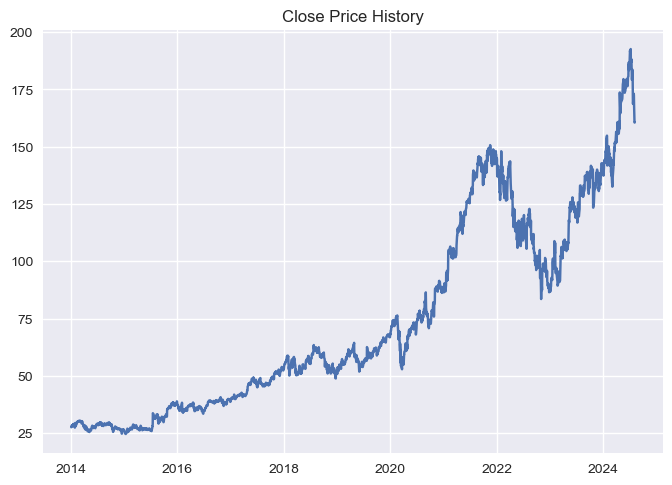

In [251]:
plt.title('Close Price History')
plt.plot(df['Close'])
plt.show()

In [274]:
#Replacing the date index to default
#Isolating close prices
data = df.filter(['Close'])[-1403:]
data.reset_index(inplace=True, drop=True)
data

,Close
0,53.516499
1,52.859501
2,52.234501
3,53.857498
4,54.048500
...,...
1398,172.449997
1399,168.399994
1400,160.639999
1401,160.539993


<font size=6>Calculating RSI</font>

In [275]:
#Calculating RSI for predicting overbought/oversold stocks
window_length = 14
delta = data['Close'].diff().dropna()
loss = delta.copy()
gains = delta.copy()

gains[gains < 0] = 0
loss[loss > 0] = 0

#Using ewm(Exponential moving average) instead of sma as this smoothes the gains and losses.
#It gives more weight to recent price changes and less to the older ones
gain_ewm = gains.ewm(com=window_length - 1, adjust=False).mean()
loss_ewm = abs(loss.ewm(com=window_length - 1, adjust=False).mean())

RS = gain_ewm / loss_ewm
RSI = 100 - 100 / (1 + RS)
data['RSI'] = RSI
data['RSI'].fillna(0,inplace = True)
data[-20:]

,Close,RSI
1383,187.300003,57.823823
1384,186.779999,56.718466
1385,188.190002,59.006731
1386,185.500000,53.225258
1387,182.619995,47.822735
1388,179.220001,42.356721
1389,179.389999,42.709312
1390,183.350006,50.330895
1391,183.600006,50.776106
1392,174.369995,37.434718


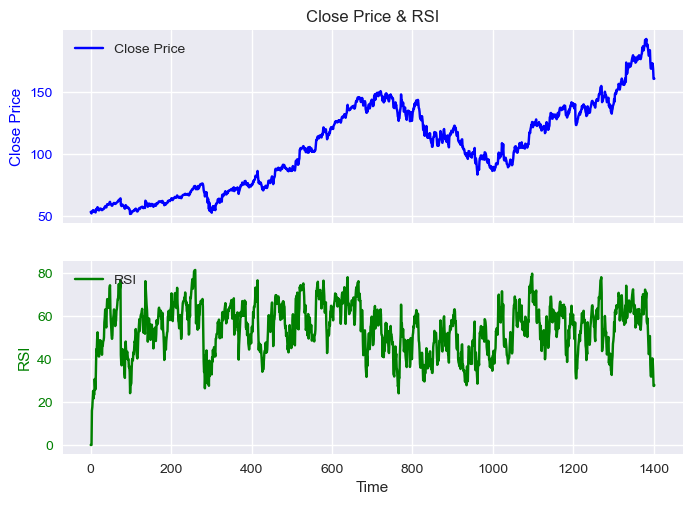

In [276]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(data['Close'], color='blue', label='Close Price')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Close Price & RSI")

ax2.plot(data['RSI'], color='green', label='RSI')
ax2.set_ylabel('RSI', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_xlabel('Time')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.show()

<font size=6>API Call for Financial News</font>

In [277]:
# Input your API key
api_key = os.getenv('news_key')
# Gets Financial News with a limit of 1000
url = f'https://eodhd.com/api/sentiments?s=GOOG&from={start}&to={end}&api_token={api_key}&fmt=json'
news_data = requests.get(url).json()

In [278]:
news_df = pd.DataFrame(news_data['GOOG.US'])
sentiments = news_df['normalized'][::-1].reset_index(drop=True)
sentiments = np.array(sentiments)
sentiments

array([0.991 , 0.999 , 0.992 , ..., 0.6063, 0.7001, 0.8718])

In [279]:
data['Sentiment'] = sentiments
data

,Close,RSI,Sentiment
0,53.516499,0.000000,0.9910
1,52.859501,0.000000,0.9990
2,52.234501,0.000000,0.9920
3,53.857498,16.014964,0.9970
4,54.048500,17.685692,0.9960
...,...,...,...
1398,172.449997,39.464509,0.9850
1399,168.399994,34.591627,0.3914
1400,160.639999,27.567823,0.6063
1401,160.539993,27.490354,0.7001


<font size=6>Preparing Data for Neural Network</font>

In [280]:
# Training Data consists of 80% of data
# We do not use train_test_split on time series forcast since it randomly splits data, which would affect results
train_len = int(0.8 * len(data))

train_data = data[:train_len]
test_data = data[train_len:]

# We split the data before passing to scaler, because we do not want the scaler to see test data.
# This would result in data leakage.
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# We calculate for the last 60 days.
x_train = []
y_train = []
for i in range(60,len(train_scaled)):
    x_train.append(train_scaled[i-60:i])
    y_train.append(train_scaled[i,0])

x_test = []
y_test = []
for i in range(60,len(test_scaled)):
    x_test.append(test_scaled[i-60:i])
    y_test.append(test_scaled[i,0])

# These are now 3D arrays. We need 3D arrays for LSTM input
x_train_arr = np.array(x_train)
x_test_arr = np.array(x_test)
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)



<font size=6>Constructing the Neural Network</font>

In [281]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_arr.shape[1],3)))
model.add(LSTM(units=60))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

2024-08-09 22:57:48.931906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-09 22:57:48.932573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-09 22:57:48.933592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<font size=6>Training the Model</font>

In [282]:
model.fit(x_train_arr,y_train_arr,epochs=50,batch_size=32)
model.summary()

Epoch 1/50


2024-08-09 22:57:52.250793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-09 22:57:52.251581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-09 22:57:52.252498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 2s 25ms/step - loss: 0.0355
Epoch 2/50
34/34 [==============================] - 1s 23ms/step - loss: 0.0022
Epoch 3/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0018
Epoch 4/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0016
Epoch 5/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0015
Epoch 6/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0014
Epoch 7/50
34/34 [==============================] - 1s 24ms/step - loss: 0.0013
Epoch 8/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0013
Epoch 9/50
34/34 [==============================] - 1s 26ms/step - loss: 0.0012
Epoch 10/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0012
Epoch 11/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0012
Epoch 12/50
34/34 [==============================] - 1s 25ms/step - loss: 0.0011
Epoch 13/50
34/34 [=============================

<font size=6>Evaluating the Model</font>

In [288]:
predicted_price = model.predict(x_test_arr)
predicted_price_full = np.concatenate((predicted_price, np.zeros((predicted_price.shape[0], 2))), axis=1)
predicted_price = scaler.inverse_transform(predicted_price_full)[:, 0]
predicted_price
mse = mean_squared_error(data['Close'][-221:],predicted_price)
rmse = (mse)**(1/2)
rmse


7/7 [==============================] - 0s 6ms/step


3.4186497586130193

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


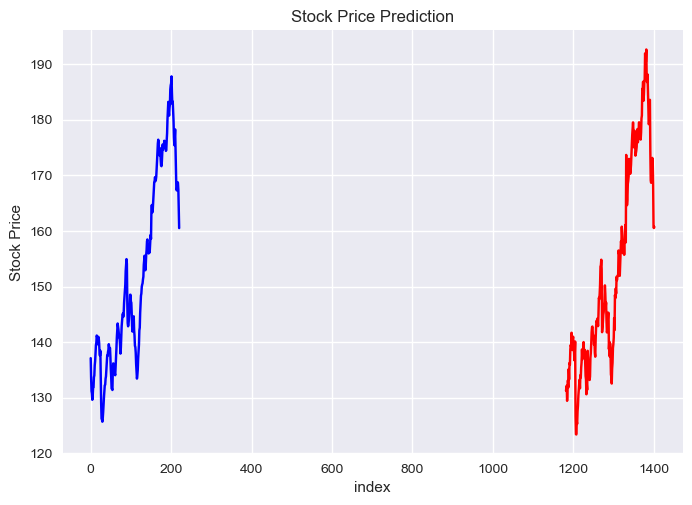

In [286]:
plt.plot(data['Close'][-221:],color='red')
plt.plot(predicted_price,color='blue')
plt.title('Stock Price Prediction')
plt.xlabel('index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()